In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
""" 
Main data
"""
sub_path = "C:/Users/mvmigem/Documents/data/project_1/uncorrected_rERPs/"
dir_list = glob.glob(sub_path+'/*.csv')
loaded_dfs = []
roi_channels = ['Oz','O1','O2',
                'PO3','POz','PO4',
                'P1','Pz','P2',
                'CP1','CPz','CP2',
                'PO8','PO7','P4','P3',
                'C5','C3','CP5','CP3',
                'C4','C6','CP4','CP6',
                ]

for p in dir_list:
    df_sub = pd.read_csv(p)
    df_sub = df_sub[df_sub['channel'].isin(roi_channels)]
    loaded_dfs.append(df_sub)

df = pd.concat(loaded_dfs,ignore_index=True)
# Drop non EEG channels
df = df[~df['channel'].isin(['eye_above','eye_below','eye_left','eye_right','Status'])]
max_time = .6 # change this depending on the ERP you want to look at
df = df[df['time'] < max_time]

In [3]:
peak_prop_path = "C:/Users/mvmigem/Documents/data/project_1/compiled_dataframes/c1_peak_properties.csv"
peak_prop = pd.read_csv(peak_prop_path)
best_pairs = list(zip(peak_prop['subject'], peak_prop['all_pos_peak_channel']))
df['selected_ch'] = df[['subject', 'channel']].apply(tuple, axis=1).isin(best_pairs)
df['visual_field'] = np.where(df['position'].isin([1, 2]), 'up', 'down')

In [4]:
baseline_period = df['time'] <0
baseline_means = df[baseline_period].groupby(['subject','channel','visual_field','attention','expectation'])['yhat'].mean() #,'visual_field'

df['y_bc'] = df.apply(
    lambda row: row['yhat'] - baseline_means[(row['subject'],row['channel'],row['visual_field'], row['attention'], row['expectation'])], #,row['visual_field']
    axis=1
)

C:\Users\mvmigem\AppData\Local\Temp\ipykernel_20916\4214382597.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df[df['visual_field']=='up'][df['channel'].isin(["PO7","PO3","O1","PO8","PO4","O2"])],
C:\Users\mvmigem\AppData\Local\Temp\ipykernel_20916\4214382597.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=df[df['visual_field']=='down'][df['channel'].isin(["PO7","PO3","O1","PO8","PO4","O2"])],


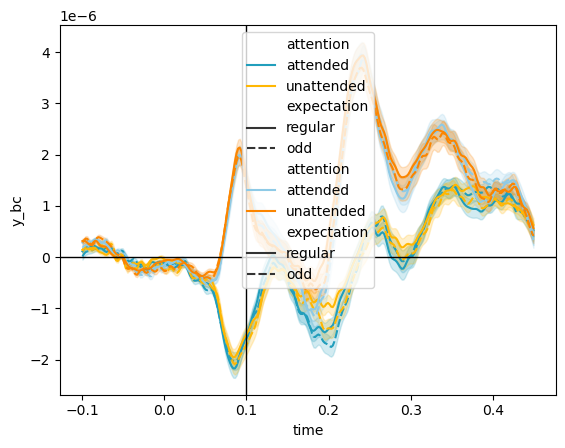

In [ ]:
line_colours1= ['#219EBC','#FFB703']
line_colours2 = ['#8ECAE6','#FB8500',]
line_colours = ['#219EBC','#FFB703','#8ECAE6','#FB8500']

side = 'down'
y = 'y_bc'

fig, ax = plt.subplots(1,1,sharey=False,sharex=False)
sns.lineplot(data=df[df['selected_ch']][df['visual_field']=='up'],
            x='time',y= y,
            hue='attention',style='expectation',
            palette=line_colours1, errorbar='se')

sns.lineplot(data=df[df['selected_ch']][df['visual_field']=='down'],
            x='time',y= y,
            hue='attention',style='expectation',
            palette=line_colours2,errorbar='se')

ax.axhline(y=0, lw=1, c='black' )
ax.axvline(x=0.1, lw=1, c='black' )

In [ ]:

line_colours1= ['#219EBC','#FFB703']
line_colours2 = ['#8ECAE6','#FB8500',]

side = 'down'
y = 'y_bc'


sns.lineplot(data=df[df['channel'].isin(["PO7","PO3","O1","PO8","PO4","O2"])],
            x='time',y=y,
            hue='attention',style='expectation',
            palette=line_colours1,
            errorbar='se')

ax.axhline(y=0, lw=1, c='black' )
ax.axvline(x=0.1, lw=1, c='black' )

In [ ]:
""" 
Select the C1 to analyse
"""
peak_properties = pd.read_csv(r'C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes\c1_peak_properties.csv')
##  C1 time window
# Window search
c1_tmin = 0.06
c1_tmax = 0.09
c1_timwid = 0.01
c1_sampwid = int(c1_timwid*512)

subject_list = df['subject'].unique()
winidx_c1 = []
df_1 = df[df['selected_ch']].copy().reset_index()
df_2 = df[df['channel'] == 'POz'].copy().reset_index()
for n,df in enumerate([df_1,df_2]):
    indexes_peak = []
    for sub in subject_list:
        sub_df = df[df['subject']== sub]
        peak_time = peak_properties[peak_properties['subject'] == sub]['all_pos_peak_latency'].iloc[0]
        peak_indx = np.array(sub_df[sub_df['time'] == peak_time]['index'])
        indexes_peak = np.concatenate([indexes_peak,peak_indx],axis=0)
    # Select window around it
    winidx_c1_n = []
    for i, idx in enumerate(indexes_peak):
        win_li = np.arange(idx - c1_sampwid, idx + c1_sampwid +1)
        winidx_c1_n = np.concatenate([winidx_c1_n,win_li],axis=0)
    winidx_c1.append(winidx_c1_n)

winidx_c1_1 = winidx_c1[0].astype(int)
winidx_c1_2 = winidx_c1[1].astype(int)
# Apply to df
c1_win_df_1 = df_1[df_1['index'].isin(winidx_c1_1)]
c1_means_df_1 = c1_win_df_1.groupby(['subject','attention','expectation','visual_field'])['y_bc'].mean().reset_index()

# Apply to df
c1_win_df_2 = df_2[df_2['index'].isin(winidx_c1_2)]
c1_means_df_2 = c1_win_df_2.groupby(['subject','attention','expectation','visual_field'])['y_bc'].mean().reset_index()

In [ ]:
sns.set_style('whitegrid')
sns.set_context("paper")

line_colours1= ['#219EBC','#FFB703','#8ECAE6','#FB8500',]

g = sns.catplot(data= c1_means_df_1, y = 'y_bc', x = 'attention',
            hue = 'expectation', col = 'visual_field',
            kind = 'bar',
            edgecolor= 'black',
            errorbar='se',
            linewidth=0.7, 
            palette=line_colours1)
g = sns.catplot(data= c1_means_df_2, y = 'y_bc', x = 'attention',
            hue = 'expectation', col = 'visual_field',
            kind = 'bar',
            edgecolor= 'black',
            errorbar='se',
            linewidth=0.7, 

            palette=line_colours1)

plt.show()

In [ ]:
destination_folder = r"C:\Users\mvmigem\Documents\data\project_1\compiled_dataframes/"
c1_means_df_1['amp'] = c1_means_df_1['y_bc'] * 1e6
c1_means_df_2['amp'] = c1_means_df_2['y_bc'] * 1e6
c1_means_df_1.to_csv(destination_folder + "uc_rerp_c1_var_df.csv")
c1_means_df_2.to_csv(destination_folder + "uc_rerp_c1_fix_df.csv")

In [ ]:
subject_list = df['subject'].unique()
# # Window selection P1
comp_tmin = 0.1
comp_tmax = 0.15
comp_timwid = 0.015
comp_sampwid = int(comp_timwid*512)
measure = 'y_bc'
df_comp = df[df['channel'].isin(["PO7","PO3","O1","PO8","PO4","O2"])] # P1

"""" 
ERP measure extraction
"""

# Select the place to search for peak
df_win = df_comp[(df_comp['time']>comp_tmin) & (df_comp['time']< comp_tmax )]

# Find time point in main df
indexes_peak =[]
for sub in subject_list:
    sub_df = df_win[df_win['subject'] == sub] 
    mean_window = sub_df.groupby(['time'])['y_bc'].mean().reset_index()
    peak_latency = mean_window.loc[mean_window['y_bc'].idxmax()]['time'] # All Positive ERP's
    # peak_latency = mean_window.loc[mean_window['y_bc'].idxmin()]['time'] # N1
# Find matching rows in df
    peak_indx = np.array(sub_df[
        (sub_df['time'] >= peak_latency - (1/512)) & 
        (sub_df['time'] <= peak_latency + (1/512))].index)
    indexes_peak = np.concatenate([indexes_peak,peak_indx],axis=0)
winidx = []
# Select window around it
for i, idx in enumerate(indexes_peak):
    win_li = np.arange(idx - comp_sampwid, idx + comp_sampwid +1)
    winidx.extend(win_li)

# Apply to df
# Apply to df
comp_win_df = df_comp[df_comp.index.isin(winidx)]
comp_win_df['peak_latency'] =  df_comp.loc[indexes_peak]['time']
comp_means_df = comp_win_df.groupby(['subject',
                                     'attention',
                                     'expectation'])[['y_bc','peak_latency']].mean().reset_index()
comp_means_df['y_bc'] = comp_means_df['y_bc'] *1e6

In [ ]:
sns.set_style('whitegrid')
sns.set_context("paper")

line_colours1= ['#219EBC','#FFB703','#8ECAE6','#FB8500',]

g = sns.catplot(data= comp_means_df, y = 'y_bc', x = 'attention',
            hue = 'expectation',
            kind = 'bar',
            edgecolor= 'black',
            errorbar='se',
            linewidth=0.7,
            palette=line_colours1)

plt.show()

In [ ]:
output_path = f"C:/Users/mvmigem/Documents/data/project_1/compiled_dataframes/uc_rerp_p1.csv"
comp_means_df.to_csv(output_path)

In [ ]:
# Paper figure C1
fig, axes = plt.subplots(1,2,figsize= (10,6), sharey=False,sharex=False)
sns.set_context("paper")
sns.set_style("white")

line_colours1= ['#219EBC','#FFB703']
line_colours2 = ['#8ECAE6','#FB8500',]

df['y_µV'] = df['y_bc'] *1e6
c1_means_df_1['y_µV'] = c1_means_df_1['y_bc'] *1e6

side = 'down'
y = 'y_µV'

sns.lineplot(data=df[df['selected_ch']][df['visual_field']=='up'],
            x='time',y= y,
            hue='attention',style='expectation',
            palette=line_colours1, errorbar='se',ax=axes[0])

sns.lineplot(data=df[df['selected_ch']][df['visual_field']=='down'],
            x='time',y= y,
            hue='attention',style='expectation',
            palette=line_colours2,errorbar='se',ax=axes[0])

axes[0].axhline(y=0, lw=1, c='black' )
axes[1].axhline(y=0, lw=1, c='black' )

# Legend
# Collect handles and labels from the first axis
handles, labels = axes[0].get_legend_handles_labels()
to_pop = [3,3,3]
for i in to_pop:
    handles.pop(i)
    labels.pop(i)
# Add a single legend to the figure

legend = fig.legend(handles, labels, ncol=1, bbox_to_anchor=(1.1,.9),prop={'size': 12, 'family': 'Segoe UI'})
legend.texts[0].set_text("Attention UFV")
legend.texts[1].set_text("peripheral")
legend.texts[2].set_text("central")
legend.texts[3].set_text("Attention LFV")
legend.texts[4].set_text("peripheral")
legend.texts[5].set_text("central")
legend.texts[6].set_text("Expectation")
legend.texts[0].set_fontweight("semibold")
legend.texts[3].set_fontweight("semibold")
legend.texts[6].set_fontweight("semibold")
axes[0].legend_.remove() 


# Labels
axes[0].set_xlabel('time (s)',fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':16})
axes[0].set_ylabel('µV',fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':16})
axes[1].set_ylabel('')
axes[1].set_xlabel('expectation',fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':16})

# Bar + scatterplot
sns.barplot(c1_means_df_1[c1_means_df_1['visual_field'] == 'up'],
            y=y,
            x='expectation',
            hue='attention',
            edgecolor= 'none', 
            palette= line_colours1,
            errorbar='se', 
            errwidth= 3, 
            order= ['regular','odd'],
            capsize=.08,
            width=.3, 
            linewidth=0.3,
            ax = axes[1])
sns.stripplot(data=c1_means_df_1[c1_means_df_1['visual_field'] == 'up'],
              y=y,
              x='expectation',
              hue='attention',
              dodge=True,
              palette=line_colours1,
              order=['regular', 'odd'],
              ax=axes[1],
              jitter= 0.05,
              size=7,
              alpha=1) 

sns.barplot(c1_means_df_1[c1_means_df_1['visual_field'] == 'down'],y=y,x='expectation',hue='attention',edgecolor= 'none', palette= line_colours2,
            errorbar='se', errwidth= 3,
            capsize=.08,width=.3, linewidth=0.3,ax = axes[1])
sns.stripplot(data=c1_means_df_1[c1_means_df_1['visual_field'] == 'down'],
              y=y,
              x='expectation',
              hue='attention',
              dodge=True,  # Prevents overlapping
              palette=line_colours2,
              order=['regular', 'odd'],
              ax=axes[1],
              jitter= 0.05,
              size=7,  # Adjust point size
              alpha=1) 
# Get current y-limits for both axes
y1_min, y1_max = axes[0].get_ylim()
y2_min, y2_max = axes[1].get_ylim()

# Calculate the maximum absolute range from zero
max_range1 = max(abs(y1_min), abs(y1_max))
max_range2 = max(abs(y2_min), abs(y2_max))

# Set symmetric limits around zero
axes[0].set_ylim(-max_range1, max_range1)
axes[1].set_ylim(-max_range2, max_range2)

axes[0].axvspan(.050, .100, color='gray', alpha=0.3, label='Highlight')
axes[0].tick_params(axis='x', labelsize=18) 
axes[0].set_xlim(-.05,0.2)
axes[0].set_ylabel('µV', fontdict={'family': 'Segoe UI','size':14})
axes[1].set_ylabel('', fontdict={'family': 'Segoe UI','size':20})
axes[0].tick_params(axis='both', labelsize=14) 
axes[1].tick_params(axis='both', labelsize=14) 
axes[1].legend_.remove() 
sns.despine(offset=10, trim=True)

In [ ]:
# Paper figure
fig, axes = plt.subplots(1,2,figsize= (10,6), sharey=False,sharex=False)
sns.set_context("paper")
sns.set_style("white")

line_colours1= ['#219EBC','#FFB703']
line_colours2 = ['#8ECAE6','#FB8500',]

df['y_µV'] = df['y_bc'] *1e6


side = 'down'
y = 'y_µV'
y2 = 'y_bc'

sns.lineplot(data=df[df['channel'].isin(["PO7","PO3","O1","PO8","PO4","O2"])],
            x='time',y= y,
            hue='attention',style='expectation',
            palette=line_colours1, errorbar='se',ax=axes[0])


axes[0].axhline(y=0, lw=1, c='black' )
axes[1].axhline(y=0, lw=1, c='black' )

# Legend
# Collect handles and labels from the first axis
handles, labels = axes[0].get_legend_handles_labels()
to_pop = [3,3,3]
for i in to_pop:
    handles.pop(i)
    labels.pop(i)
# Add a single legend to the figure

handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, ncol=1, bbox_to_anchor=(1.05, .9),prop={'size': 12, 'family': 'Segoe UI'})
legend.texts[0].set_text("Attention")
legend.texts[1].set_text("peripheral")
legend.texts[2].set_text("central")
legend.texts[3].set_text("Expectation")
legend.texts[0].set_fontweight("semibold")
legend.texts[3].set_fontweight("semibold")
axes[0].legend_.remove() 


# Labels
axes[0].set_xlabel('time (s)',fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':16})
axes[0].set_ylabel('µV',fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':16})
axes[1].set_ylabel('')
axes[1].set_xlabel('expectation',fontdict={'family': 'Segoe UI', 'weight' : 'semibold','size':16})

# Bar + scatterplot
sns.barplot(comp_means_df,
            y=y2,
            x='expectation',
            hue='attention',
            edgecolor= 'none', 
            palette= line_colours1,
            errorbar='se', 
            errwidth= 3, 
            order= ['regular','odd'],
            capsize=.08,
            width=.3, 
            linewidth=0.3,
            ax = axes[1])
sns.stripplot(data=comp_means_df,
              y=y2,
              x='expectation',
              hue='attention',
              dodge=True,
              palette=line_colours1,
              order=['regular', 'odd'],
              ax=axes[1],
              jitter= 0.05,
              size=7,
              alpha=1) 



axes[0].axvspan(.1, .150, color='gray', alpha=0.3, label='Highlight')
axes[0].tick_params(axis='x', labelsize=18) 
axes[0].set_xlim(-.05,0.3)
axes[0].set_ylabel('µV', fontdict={'family': 'Segoe UI','size':14})
axes[1].set_ylabel('', fontdict={'family': 'Segoe UI','size':20})
axes[0].tick_params(axis='both', labelsize=14) 
axes[1].tick_params(axis='both', labelsize=14) 
axes[1].legend_.remove() 
sns.despine(offset=10, trim=True)